In [1]:
# p269

In [2]:
# https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/blob/master/5.TEXT_SIM/5.3.3_Quora_LSTM.ipynb
# 이놈은 뭐지? 참고?

In [3]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [5]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [7]:
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [8]:
model_name = 'malstm_similarity'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {'vocab_size':prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'lstm_dimension': 150}

In [9]:
# 모델은 의외로 간단
class MaLSTM(tf.keras.Model):
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1,
                                         output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])
        
        # 이러면 끝
        
    def call(self, x):
        x1, x2 = x  # 언페킹
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        
        # 각각을 LSTM 별도로 통과시킴
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        
        # 유사도를 구해보기
        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))
        
        return x
    
    # 둘 사이의 멘하탄 거리를
    # 어떻게 조작을 하면
    # 멘하탄 거리가 가까울수록, 유사도가 높은 것(유사도를 1로 치고)
    # 멀수록 0에 근접할 것

In [10]:
model = MaLSTM(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),  # 손실 함수
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [11]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, 
                                   patience=3)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)  # 폴더 생성
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=True)

./data_out/malstm_similarity -- Folder create complete 



In [12]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
2100/2100 [==============================] - 60s 26ms/step - loss: 0.5306 - accuracy: 0.7368 - val_loss: 0.5342 - val_accuracy: 0.7502

Epoch 00001: val_accuracy improved from -inf to 0.75017, saving model to ./data_out/malstm_similarity\weights.h5
Epoch 2/5
2100/2100 [==============================] - 54s 26ms/step - loss: 0.4021 - accuracy: 0.8209 - val_loss: 0.5236 - val_accuracy: 0.7694

Epoch 00002: val_accuracy improved from 0.75017 to 0.76936, saving model to ./data_out/malstm_similarity\weights.h5
Epoch 3/5
2100/2100 [==============================] - 54s 26ms/step - loss: 0.3545 - accuracy: 0.8471 - val_loss: 0.4780 - val_accuracy: 0.8051

Epoch 00003: val_accuracy improved from 0.76936 to 0.80511, saving model to ./data_out/malstm_similarity\weights.h5
Epoch 4/5
2100/2100 [==============================] - 54s 26ms/step - loss: 0.3185 - accuracy: 0.8660 - val_loss: 0.4570 - val_accuracy: 0.8185

Epoch 00004: val_accuracy improved from 0.80511 to 0.81853, saving mode

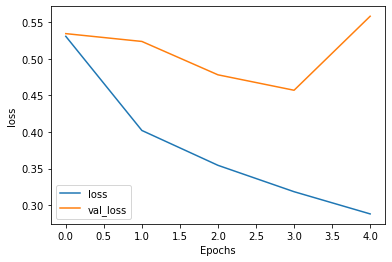

In [15]:
plot_graphs(history, 'loss')

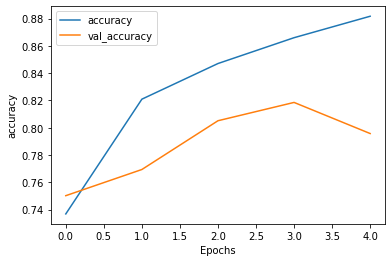

In [16]:
plot_graphs(history, 'accuracy')

In [17]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [18]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [19]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

In [21]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(DATA_OUT_PATH + "rnn_predict.csv", index=False, quoting=3)

In [ ]:
# https://www.kaggle.com/c/quora-question-pairs/submit
# 캐글 채점